In [1]:
import gc, os
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import json

import joblib
from joblib import Parallel, delayed

from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, normalize

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import math

from numerapi import NumerAPI
from src.config import load_features, load_validation_data, load_train_data

In [2]:
feature_set = load_features("medium")

train = load_train_data(feature_set)

validation = load_validation_data(feature_set, train)

In [3]:
TARGET_NAME = "target"
PREDICTION_NAME = "prediction"


target_names =["target"]

# all eras of TARGET_NAME must be present in diagnostics
validation = validation.dropna(subset=[TARGET_NAME], axis=0).copy()
gc.collect()

train["era_int"] = train["era"].astype(int)
validation["era_int"] = validation["era"].astype(int)
gc.collect()

for feature_name in tqdm(feature_set):
    train.loc[:, feature_name]=train.loc[:, feature_name].fillna(-2)
    validation.loc[:, feature_name]=validation.loc[:, feature_name].fillna(-2)

for target_name in tqdm(target_names):
    train.loc[:, target_name]=train.loc[:, target_name].fillna(0.5)
    validation.loc[:, target_name]=validation.loc[:, target_name].fillna(0.5)

gc.collect()

device = "cuda" if torch.cuda.is_available() else "cpu"

100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


In [5]:
target_names =["target"]

In [6]:
PADDING_VALUE = -1
MAX_LEN = 6000
FEATURE_DIM = len(feature_set)
HIDDEN_DIM = 64
OUTPUT_DIM = 1
NUM_HEADS = 4
NUM_LAYERS = 4

In [7]:
def pad_sequence(inputs, padding_value=-1, max_len=None):
    if max_len is None:
        max_len = max([input.shape[0] for input in inputs])
    padded_inputs = []
    masks = []
    for input in inputs:
        pad_len = max_len - input.shape[0]
        padded_input = F.pad(input, (0, 0, 0, pad_len), value=padding_value)
        mask = torch.ones((input.shape[0], 1), dtype=torch.float)
        masks.append(
            torch.cat((mask, torch.zeros((pad_len, 1), dtype=torch.float)), dim=0)
        )
        padded_inputs.append(padded_input)
    return torch.stack(padded_inputs), torch.stack(masks)

def convert_to_torch(era, data):

    inputs = torch.from_numpy(
                data[feature_set].values.astype(np.int8))
    labels = torch.from_numpy(
                data[target_names].values.astype(np.float32))

    padded_inputs, masks_inputs = pad_sequence(
            [inputs], padding_value=PADDING_VALUE, max_len=MAX_LEN)
    padded_labels, masks_labels = pad_sequence(
            [labels], padding_value=PADDING_VALUE, max_len=MAX_LEN)

    return {
        era: (
            padded_inputs,
            padded_labels,
            masks_inputs
        )
    }

def get_era2data(df):
    res = Parallel(n_jobs=-1, prefer="threads")(
        delayed(convert_to_torch)(era, data)
        for era, data in tqdm(df.groupby("era_int")))
    era2data = {}
    for r in tqdm(res):
        era2data.update(r)
    return era2data

era2data_train = get_era2data(train)
era2data_validation = get_era2data(validation)

  0%|          | 0/574 [00:00<?, ?it/s]

100%|██████████| 137/137 [00:00<?, ?it/s]


In [8]:
class PositionalEncoding(nn.Module):
    """
    Didn't have much difference
    """

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-torch.log(torch.tensor(10000.0)) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)


class FeedForwardLayer(nn.Module):
    def __init__(self, d_model, d_ff=128, dropout=0.1):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

class ModularAttentionDev(nn.Module):
    def __init__(self, d_model, attention_type="linear", dropout=0.1, window_size=4):
        super().__init__()
        self.dim = d_model
        self.attention_type = attention_type
        self.dropout = nn.Dropout(dropout)
        self.window_size = window_size

    def forward(self, k, q, v, mask=None):
        n = math.sqrt(self.dim)

        if self.attention_type == "vanilla":
            scores = torch.matmul(q, k.transpose(-2, -1)) / n

            if mask is not None:
                scores = scores.masked_fill(mask.unsqueeze(1) == 0, float("-inf"))

            attn = F.softmax(scores, dim=-1)
            attn = self.dropout(attn)
            out = torch.matmul(attn, v)

        elif self.attention_type == "linear":
            scores = torch.matmul(k.transpose(-2, -1), v) / n
            if mask is not None:
                mask = mask.unsqueeze(-1)
                q = q.masked_fill(mask == 0, float("-inf"))
            denom = 1 + torch.sum(torch.exp(q), dim=1, keepdim=True)
            q = torch.exp(q) / denom
            q = self.dropout(F.softmax(q, dim=1))
            out = torch.matmul(q, scores)

        return out


class ModularAttention(nn.Module):
    def __init__(self, d_model, attention_type="linear", dropout=0.1, window_size=1000):
        super().__init__()
        self.dim = d_model
        self.attention_type = attention_type
        self.dropout = nn.Dropout(dropout)
        self.window_size = window_size

    def forward(self, k, q, v, mask=None):
        assert k.size(0) == q.size(0)
        assert k.size(0) == v.size(0)
        n = math.sqrt(self.dim)

        if self.attention_type == "vanilla":
            # Apply the sliding window to the scores calculation
            scores = self.sliding_window_scores(q, k, n)
            if mask is not None:
                scores = scores.masked_fill(mask.unsqueeze(1) == 0, float("-inf"))
            attn = F.softmax(scores, dim=-1)
            attn = self.dropout(attn)
            out = torch.matmul(attn, v)

        elif self.attention_type == "linear":
            # Linear attention code remains the same
            scores = torch.matmul(k.transpose(-2, -1), v) / n
            if mask is not None:
                mask = mask.unsqueeze(-1)
                q = q.masked_fill(mask == 0, float("-inf"))
            denom = 1 + torch.sum(torch.exp(q), dim=1, keepdim=True)
            q = torch.exp(q) / denom
            q = self.dropout(F.softmax(q, dim=1))
            out = torch.matmul(q, scores)

        return out

    def sliding_window_scores(self, q, k, scale):
        batch_size, num_heads, num_queries, head_dim = q.size()
        _, _, num_keys, _ = k.size()

        scores = torch.zeros(batch_size, num_heads, num_queries, num_keys, device=q.device)
        for i in (range(0, num_queries, self.window_size)):
            # Calculate the start and end index of the window
            start = max(0, i - self.window_size // 2)
            end = min(num_keys, i + self.window_size // 2 + 1)

            # Compute attention scores for the window
            q_slice = q[:, :, i:i+1, :]  # Keep the tensor 4D
            k_slice = k[:, :, start:end, :].transpose(2, 3)
            window_scores = torch.matmul(q_slice, k_slice) / scale
            scores[:, :, i, start:end] = window_scores.squeeze(2)  # Remove the extra dimension after matmul

        return scores

class MultiHeadModularAttention(nn.Module):
    def __init__(self, d_model, num_heads, attention_type="linear", dropout=0.1):
        """
        Multi-head attention module that applies a modular attention mechanism
        to the input tensor.

        Args:
            d_model (int): The number of expected features in the input.
            num_heads (int): The number of parallel attention heads.
            attention_type (str): The type of attention mechanism to use.
                Defaults to "linear".
            dropout (float): The dropout probability. Defaults to 0.1.
        """
        super().__init__()
        self.num_heads = num_heads
        self.attention = ModularAttention(d_model, attention_type, dropout)
        self.head_dim = d_model // num_heads

        # Linear transformations for keys, queries, and values
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)

        # Linear transformation for output
        self.output_linear = nn.Linear(d_model, d_model)

        # Dropout and layer normalization
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def split_heads(self, x, batch_size):
        """
        Split the last dimension of the input tensor into multiple heads.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, seq_len, d_model).
            batch_size (int): The size of the batch.

        Returns:
            torch.Tensor: The tensor with the last dimension split into multiple heads of shape
            (batch_size, num_heads, seq_len, head_dim).
        """
        x = x.view(batch_size, -1, self.num_heads, self.head_dim).clone()
        return x.permute(0, 2, 1, 3)

    def forward(self, inputs, mask=None):
        """
        Forward pass of the multi-head attention module.

        Args:
            inputs (torch.Tensor): The input tensor of shape (batch_size, seq_len, d_model).
            mask (torch.Tensor): The mask tensor of shape (batch_size, seq_len). Defaults to None.

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, seq_len, d_model).
        """

        batch_size = inputs.size(0)
        k = self.linear_k(inputs)
        q = self.linear_q(inputs)
        v = self.linear_v(inputs)

        # Split keys, queries, and values into multiple heads
        k, q, v = [self.split_heads(x, batch_size) for x in [k, q, v]]

        if mask is not None:
            mask = mask.unsqueeze(1)  # .unsqueeze(2)

        # Apply the attention mechanism
        attn_output = self.attention(k, q, v, mask)
        # Reshape the output tensor
        attn_output = (
            attn_output.permute(0, 2, 1, 3)
            .clone()
            .contiguous()
            .view(batch_size, -1, self.num_heads * self.head_dim)
        )

        # Apply linear transformation and layer normalization
        output = self.output_linear(attn_output)
        output = self.layer_norm(output)

        return output


class TransformerEncoder(nn.Module):
    def __init__(
        self,
        input_dim,
        d_model,
        output_dim,
        num_heads,
        num_layers,
        dropout_prob=0.15,
        max_len=5000,
    ):
        super(TransformerEncoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob
        self.d_model = d_model

        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model),
        )
        # Encoder layers
        self.layers = nn.ModuleList(
            [
                nn.Sequential(
                    MultiHeadModularAttention(
                        d_model, num_heads, attention_type="vanilla"
                    ),  # multi-head attention
                    nn.LayerNorm(d_model),  # layer normalization
                    FeedForwardLayer(
                        d_model=d_model
                    ),  # mixture of experts
                    nn.Dropout(dropout_prob),  # dropout
                )
                for _ in range(num_layers)
            ]
        )
        self.mapper = nn.Sequential(
            nn.Linear(input_dim, d_model), nn.Linear(d_model, d_model)
        )

    def forward(self, inputs, mask=None):

        x = self.mapper(inputs)

        # Add positional encoding; not needed in this case
        x = x + self.positional_encoding(x)

        # Apply encoder layers
        for layer in self.layers:
            layer_output = layer[0](x, mask)

            for sublayer in layer[1:]:
                layer_output = sublayer(layer_output)

            x = x + layer_output

        return x


class Transformer(nn.Module):
    def __init__(
        self,
        input_dim,
        d_model,
        output_dim,
        num_heads,
        num_layers,
        dropout_prob=0.15,
        max_len=6000,
    ):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob
        self.d_model = d_model

        self.encoder = TransformerEncoder(
            input_dim=input_dim,
            d_model=d_model,
            output_dim=output_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            max_len=max_len,
        )
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.SELU(),
            nn.Linear(d_model // 2, self.output_dim),
            nn.Sigmoid(),
        )

    def forward(self, inputs, mask=None):
        emb = self.encoder(inputs, mask)
        outputs = self.fc(emb)
        return outputs


def test_model():

    inputs = [
        torch.randint(0, 4, (5, FEATURE_DIM)).float(),
        torch.randint(0, 4, (3, FEATURE_DIM)).float(),
    ]
    labels = [
        torch.randint(0, 2, (5, OUTPUT_DIM)).float(),
        torch.randint(0, 2, (3, OUTPUT_DIM)).float(),
    ]

    padded_inputs, masks_inputs = pad_sequence(inputs, padding_value=0, max_len=MAX_LEN)
    padded_labels, masks_labels = pad_sequence(labels, padding_value=0, max_len=MAX_LEN)

    masks_inputs = masks_inputs.squeeze(-1)
    masks_labels = masks_labels.squeeze(-1)

    print(padded_inputs.shape)
    print(masks_inputs.shape)
    print(padded_labels.shape)
    print(masks_labels.shape)

    transformer = Transformer(
        input_dim=FEATURE_DIM,
        d_model=HIDDEN_DIM,
        output_dim=OUTPUT_DIM,
        num_heads=NUM_HEADS,
        num_layers=NUM_LAYERS,
        max_len=MAX_LEN,
    )

    with torch.no_grad():
        outputs = transformer(padded_inputs, masks_inputs)

    assert torch.isnan(outputs).sum() == 0
    assert outputs.shape[:2] == padded_inputs.shape[:2]
    assert outputs.shape[-1] == len(target_names)

    print("Input Shape:", padded_inputs.shape)
    print("Output Shape:", outputs.shape)
    print(outputs[0][:10, :10])

    del transformer
    del inputs, labels
    del padded_inputs, masks_inputs, padded_labels, masks_labels
    del outputs

    gc.collect()

test_model()

torch.Size([2, 6000, 705])
torch.Size([2, 6000])
torch.Size([2, 6000, 1])
torch.Size([2, 6000])
Input Shape: torch.Size([2, 6000, 705])
Output Shape: torch.Size([2, 6000, 1])
tensor([[0.5952],
        [0.3637],
        [0.5008],
        [0.5896],
        [0.5200],
        [0.5202],
        [0.5310],
        [0.5406],
        [0.5426],
        [0.4651]])


In [9]:
def pearsonr(x, y):
    mx = x.mean()
    my = y.mean()
    xm, ym = x - mx, y - my
    r_num = torch.sum(xm * ym)
    r_den = torch.sqrt(torch.sum(xm ** 2) * torch.sum(ym ** 2))
    r = r_num / r_den
    return r

In [9]:
def calculate_loss(outputs, padded_labels, masks_inputs, padded_inputs=None, target_weight_softmax=None):

    masks_inputs = masks_inputs.unsqueeze(-1)

    # MSE on all targets; additionally, on primary target
    if target_weight_softmax is not None:
        _mse = criterion(
            outputs * masks_inputs * target_weight_softmax,
            padded_labels * masks_inputs * target_weight_softmax
        ) * 0.1

    else:
        # print(outputs.shape, masks_inputs.shape, padded_labels.shape)
        _mse = criterion(outputs * masks_inputs, padded_labels * masks_inputs) * 0.1

    _mse += criterion(outputs[:, 0] * masks_inputs, padded_labels[:, 0] * masks_inputs)

    # Corr with only primary target; adjust as needed
    corr = pearsonr(
        outputs[0][:, 0][masks_inputs.view(-1).nonzero()].view(-1, 1),
        padded_labels[0][:, 0][masks_inputs.view(-1).nonzero()].view(-1, 1),
    )

    # don't optimize for corr if it's greater than 0.1; personally feels overfitting
    # corr = corr * (corr < 0.1).float()

    loss = _mse - corr #+ some_complex_constraints
    return loss, _mse, corr


# Training loop
def train_on_batch(transformer, optimizer, batch):

    padded_inputs = batch[0].to(device=device)
    padded_labels = batch[1].to(device=device)
    masks_inputs = batch[2].to(device=device)

    masks_inputs = masks_inputs.squeeze(-1)

    optimizer.zero_grad()

    outputs = transformer(padded_inputs / 4.0, masks_inputs)

    # target_weight_softmax = None
    random_weights = torch.rand(padded_labels.shape[-1], device=device)
    target_weight_softmax = F.softmax(random_weights)

    loss, _mse, _corr = calculate_loss(outputs, padded_labels, masks_inputs, target_weight_softmax=target_weight_softmax)
    loss.backward()
    optimizer.step()
    return loss.item(), _mse.item(), _corr.item()


def evaluate_on_batch(transformer, batch):

    padded_inputs = batch[0].to(device=device)
    padded_labels = batch[1].to(device=device)
    masks_inputs = batch[2].to(device=device)

    masks_inputs = masks_inputs.squeeze(-1)

    outputs = transformer(padded_inputs / 4.0, masks_inputs)
    loss, _mse, _corr = calculate_loss(outputs, padded_labels, masks_inputs)
    return loss.item(), _mse.item(), _corr.item()


def train_model(transformer, optimizer, num_epochs, train_loader, val_loader):

    train_corr = 0
    val_corr = 0

    for epoch in range(num_epochs):
        transformer.train()

        total_loss = []
        total_corr = []
        print(f"\nEPOCH: {epoch+1}/{num_epochs}")
        for era_num in tqdm(train_loader):
       
            batch = train_loader[era_num]
            loss, _mse, _corr = train_on_batch(transformer, optimizer, batch)
            total_loss.append(loss)
            total_corr.append(_corr)

            if np.isnan(loss):
                break
        print(
            f"Train Loss: {np.mean(total_loss):.4f} | Train Corr: {np.mean(total_corr):.4f}"
        )

        train_corr = np.mean(total_corr)

        transformer.eval()
        with torch.no_grad():

            total_loss = []
            total_corr = []
            for era_num in tqdm(val_loader):
                batch = val_loader[era_num]
                loss, _mse, _corr = evaluate_on_batch(transformer, batch)
                total_loss.append(loss)
                total_corr.append(_corr)
            print(
                f"Val Loss: {np.mean(total_loss):.4f} | Val Corr: {np.mean(total_corr):.4f}"
            )
        val_corr = np.mean(total_corr)

        torch.cuda.empty_cache()
        _ = gc.collect()


        # stop training if train corr is above 4 * val corr
        # no reason behind the factor. I just thing it's too much for overfitting
        if train_corr > 4 * val_corr:
            break

    torch.save(transformer.state_dict(), f"transformer_epoch_{epoch}.pth")

    return transformer

# Define the model, loss function, and optimizer

gc.collect()
transformer = Transformer(
    input_dim=FEATURE_DIM,
    d_model=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout_prob=0.25
)

# load model from checkpoint
if "transformer.pth" in os.listdir():
    transformer.load_state_dict(torch.load("transformer.pth"))

transformer.to(device=device)
criterion = nn.MSELoss()
optimizer = optim.Adam(transformer.parameters(), lr=1e-4)

# Number of training iterations
# Train for longer with low LR

num_epochs = 10
transformer = train_model(transformer, optimizer, num_epochs, era2data_train, era2data_validation)


EPOCH: 1/10


  0%|          | 0/574 [00:00<?, ?it/s]C:\Users\Paco\AppData\Local\Temp\ipykernel_18220\4265909949.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  target_weight_softmax = F.softmax(random_weights)
 79%|███████▉  | 453/574 [30:54<08:15,  4.09s/it]


KeyboardInterrupt: 

In [12]:
def predict_on_era2data(era2data, transformer, device="cpu"):

    """
    Currently returns only primary target.
    outputs[0][:, 0]: target_nomi_v4_20
    """
    transformer.eval()
    with torch.no_grad():
        preds = []
        for era_num in tqdm(era2data):
            batch = era2data[era_num]

            padded_inputs = batch[0].to(device=device)
            padded_labels = batch[1].to(device=device)
            masks_inputs = batch[2].to(device=device)

            # old implementation used [bs, seq, 1] but modified attention uses [bs, seq]
            # will fix in future
            masks_inputs = masks_inputs.squeeze(-1)

            outputs = transformer(padded_inputs / 4.0, masks_inputs)
            preds.append(
                outputs[0][masks_inputs.view(-1).nonzero()]
                .squeeze(1)
                .detach()
                .cpu()
                .numpy()
            )
    preds = np.concatenate(preds)
    return preds

In [13]:
transformer = Transformer(
    input_dim=FEATURE_DIM,
    d_model=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dropout_prob=0.25
)

# load model from checkpoint
if "transformer_epoch_9.pth" in os.listdir():
    transformer.load_state_dict(torch.load("transformer_epoch_9.pth"))


transformer.to(device=device)

C:\Users\Paco\AppData\Local\Temp\ipykernel_8272\681150250.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer.load_state_dict(torch.load("transformer_epoch_9.pt

Transformer(
  (encoder): TransformerEncoder(
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
    )
    (layers): ModuleList(
      (0-3): 4 x Sequential(
        (0): MultiHeadModularAttention(
          (attention): ModularAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (linear_k): Linear(in_features=64, out_features=64, bias=True)
          (linear_q): Linear(in_features=64, out_features=64, bias=True)
          (linear_v): Linear(in_features=64, out_features=64, bias=True)
          (output_linear): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (2): FeedForwardLayer(
          (linear_1): Linear(in

In [14]:
def unif(df):
    """from example scripts"""
    x = (df.rank(method="first") - 0.5) / len(df)
    return pd.Series(x, index=df.index)

def calculate_metrics(scores):
    return {
        "mean": scores.mean(),
        "std": scores.std(),
        "min": scores.min(),
        "max": scores.max(),
        "sharpe": scores.mean() / scores.std(),
        "max_dd": (scores.cummax() - scores).max(),
    }


torch.cuda.empty_cache()
gc.collect()

transformer = transformer.to(device)
# predict on era2data_eval
preds_train = predict_on_era2data(era2data_train, transformer, device=device)
preds_valid = predict_on_era2data(era2data_validation, transformer, device=device)



100%|██████████| 137/137 [00:53<00:00,  2.55it/s]


In [15]:
tqdm.pandas()

In [16]:
train.loc[:, PREDICTION_NAME] = preds_train[:, 0]
validation.loc[:, PREDICTION_NAME] = preds_valid[:, 0]


scores_train = (
    train[["era_int", PREDICTION_NAME, TARGET_NAME]]
    .groupby("era_int")
    .progress_apply(
        lambda d: unif(d[PREDICTION_NAME]).corr(d[TARGET_NAME])
    )
    .sort_index()
    .rename("corr")
)
scores_valid = (
    validation[["era_int", PREDICTION_NAME, TARGET_NAME]]
    .groupby("era_int")
    .progress_apply(
        lambda d: unif(d[PREDICTION_NAME]).corr(d[TARGET_NAME])
    )
    .sort_index()
    .rename("corr")
)

100%|██████████| 137/137 [00:00<00:00, 293.36it/s]


{
  "mean": 0.05390332001945039,
  "std": 0.020204765216985204,
  "min": -0.012727791782152711,
  "max": 0.11036810132038112,
  "sharpe": 2.6678518379484255,
  "max_dd": 0.12309589310253383
}


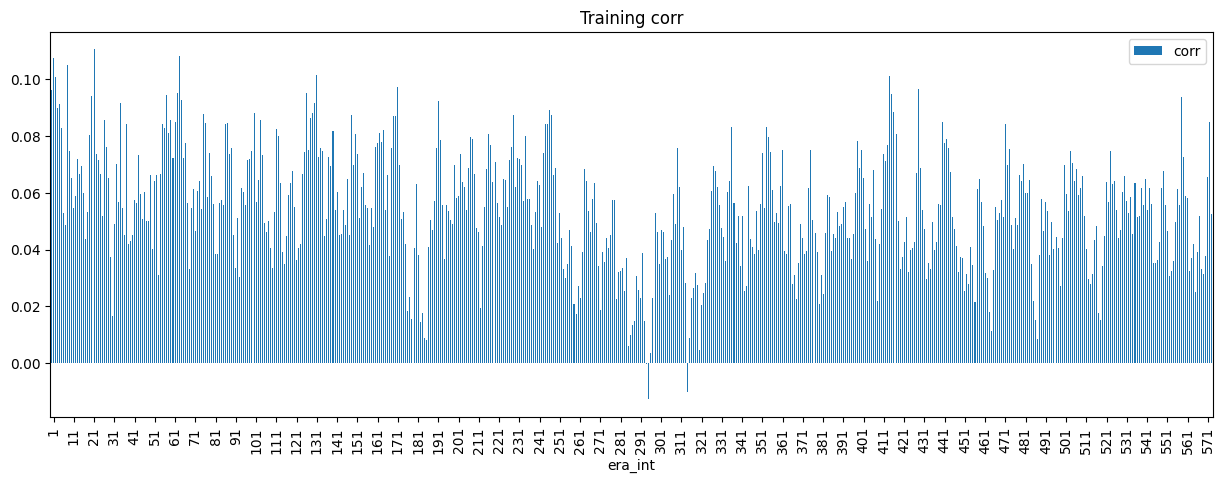

In [17]:
metrics = calculate_metrics(scores_train)
print(json.dumps(metrics, indent=2))
scores_train.reset_index().plot(
    kind="bar",
    figsize=(15, 5),
    x="era_int",
    y="corr",
    xticks=scores_train.index.to_list()[::10],
)

plt.title("Training corr")
plt.show()

{
  "mean": 0.01673357013093996,
  "std": 0.020574243827688753,
  "min": -0.036724929143427336,
  "max": 0.07438377632897894,
  "sharpe": 0.8133261310153218,
  "max_dd": 0.10691863062068724
}


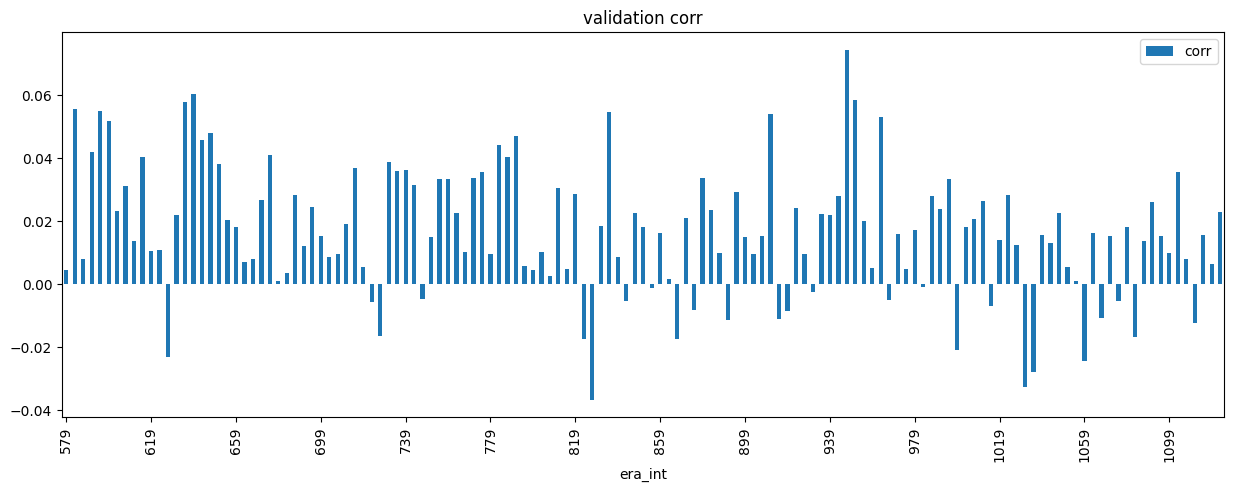

In [20]:
metrics = calculate_metrics(scores_valid)
print(json.dumps(metrics, indent=2))
scores_valid.reset_index().plot(
    kind="bar",
    figsize=(15, 5),
    x="era_int",
    y="corr",
)
plt.xticks(
    ticks=range(0, len(scores_valid), 10), labels=scores_valid.index.to_list()[::10]
)
plt.title("validation corr")
plt.show()


In [19]:
from numerai_tools.scoring import numerai_corr, correlation_contribution
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [26]:
y_test = validation["target"]
y_pred = preds_valid

validation["prediction"] = preds_valid

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

nombre_modelo="TFT"

print(nombre_modelo)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

validation["meta_model"] = pd.read_parquet(
f"v4.3/meta_model.parquet"
)["numerai_meta_model"]

TFT
Mean Absolute Error (MAE): 0.1627533882856369
Mean Squared Error (MSE): 0.050880711525678635


Mean Corr Numerai: prediction    0.018571
dtype: float64
Mean MMC Numerai: prediction    0.004678
dtype: float64


<Figure size 800x400 with 0 Axes>

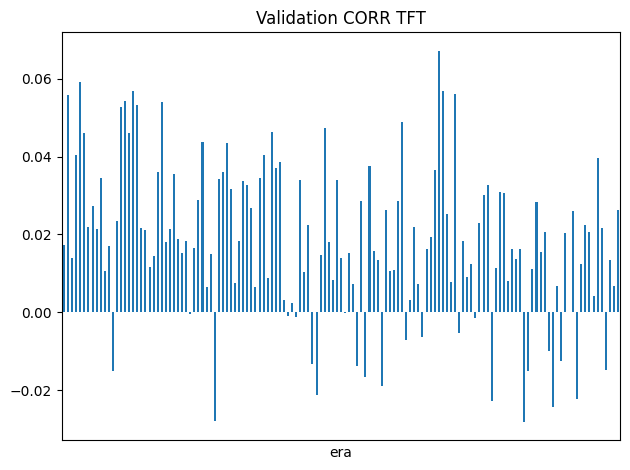

<Figure size 800x400 with 0 Axes>

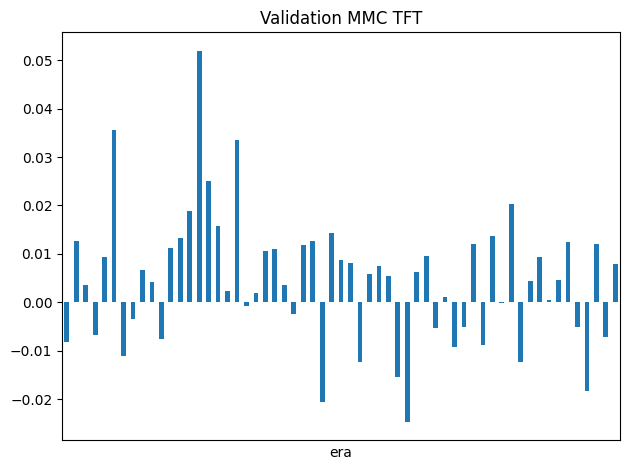

<Figure size 800x400 with 0 Axes>

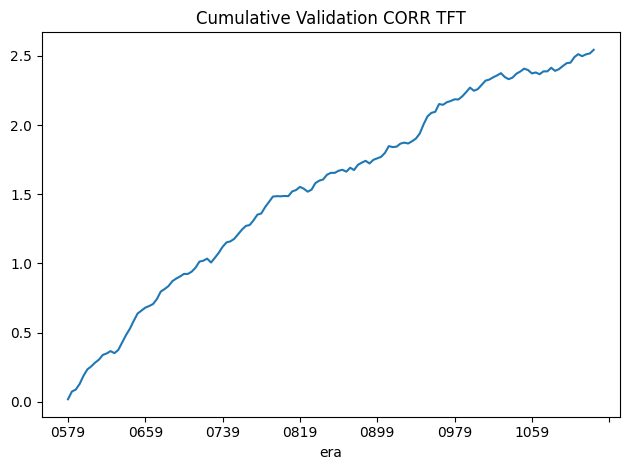

<Figure size 800x400 with 0 Axes>

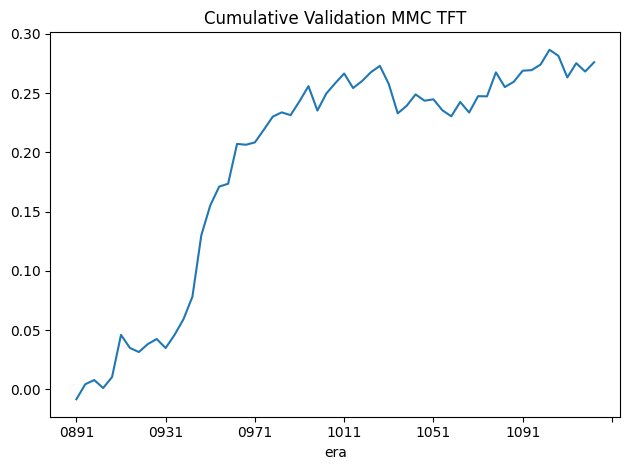

In [21]:
per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
)

# Compute the per-era mmc between our predictions, the meta model, and the target values
per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["prediction"]], x["meta_model"], x["target"])
)
mean_corr_numerai = per_era_corr.mean()

mean_mmc_numerai = per_era_mmc.mean()

print(f'Mean Corr Numerai: {mean_corr_numerai}')
print(f'Mean MMC Numerai: {mean_mmc_numerai}')

# Plot the per-era correlation
plt.figure(figsize=(8, 4))
per_era_corr.plot(
    title=f"Validation CORR {nombre_modelo}",
    kind="bar",
    xticks=[],
    legend=False
)
plt.tight_layout()
#plt.savefig(os.path.join(output_folder, f"Validation_CORR_{nombre_modelo}.png"))

# Plot the per-era MMC
plt.figure(figsize=(8, 4))
per_era_mmc.plot(
    title=f"Validation MMC {nombre_modelo}",
    kind="bar",
    xticks=[],
    legend=False
)
plt.tight_layout()
#plt.savefig(os.path.join(output_folder, f"Validation_MMC_{nombre_modelo}.png"))

# Plot the cumulative validation CORR
plt.figure(figsize=(8, 4))
per_era_corr.cumsum().plot(
    title=f"Cumulative Validation CORR {nombre_modelo}",
    kind="line",
    legend=False
)
plt.tight_layout()
#plt.savefig(os.path.join(output_folder, f"Cumulative_Validation_CORR_{nombre_modelo}.png"))

# Plot the cumulative validation MMC
plt.figure(figsize=(8, 4))
per_era_mmc.cumsum().plot(
    title=f"Cumulative Validation MMC {nombre_modelo}",
    kind="line",
    legend=False
)
plt.tight_layout()
#plt.savefig(os.path.join(output_folder, f"Cumulative_Validation_MMC_{nombre_modelo}.png"))

# Mostrar los gráficos
plt.show()

In [29]:
def extract_metrics(validation,df,  nombre_modelo, directorio, parametros,df_estadisticas):

    output_folder = directorio
    




    y_test = validation["target"]
    y_pred = validation["prediction"]

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print(nombre_modelo)

    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')

    validation["meta_model"] = pd.read_parquet(
    f"v4.3/meta_model.parquet"
)["numerai_meta_model"]


    per_era_corr = validation.groupby("era").apply(
        lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
    )

    # Compute the per-era mmc between our predictions, the meta model, and the target values
    per_era_mmc = validation.dropna().groupby("era").apply(
        lambda x: correlation_contribution(x[["prediction"]], x["meta_model"], x["target"])
    )


    # Plot the per-era correlation
    plt.figure(figsize=(8, 4))
    per_era_corr.plot(
        title=f"Validation CORR {nombre_modelo}",
        kind="bar",
        xticks=[],
        legend=False
    )
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"Validation_CORR_{nombre_modelo}.png"))

    # Plot the per-era MMC
    plt.figure(figsize=(8, 4))
    per_era_mmc.plot(
        title=f"Validation MMC {nombre_modelo}",
        kind="bar",
        xticks=[],
        legend=False
    )
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"Validation_MMC_{nombre_modelo}.png"))

    # Plot the cumulative validation CORR
    plt.figure(figsize=(8, 4))
    per_era_corr.cumsum().plot(
        title=f"Cumulative Validation CORR {nombre_modelo}",
        kind="line",
        legend=False
    )
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"Cumulative_Validation_CORR_{nombre_modelo}.png"))

    # Plot the cumulative validation MMC
    plt.figure(figsize=(8, 4))
    per_era_mmc.cumsum().plot(
        title=f"Cumulative Validation MMC {nombre_modelo}",
        kind="line",
        legend=False
    )
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, f"Cumulative_Validation_MMC_{nombre_modelo}.png"))

    # Mostrar los gráficos
    plt.show()
    mean_corr_numerai = per_era_corr.mean()

    mean_mmc_numerai = per_era_mmc.mean()
    

    print(f'Mean Corr Numerai: {mean_corr_numerai}')

    df["Target"] = y_test

    df[nombre_modelo] = y_pred


    df_estadisticas = pd.DataFrame(
    {'Modelo' : nombre_modelo , 'Parámetros' : parametros,'MAE': mae, 'MSE':mse, "Numerai Coor":mean_corr_numerai[0], 'MMC':mean_mmc_numerai[0]}
    )

    return df, df_estadisticas

TFT
Mean Absolute Error (MAE): 0.1627533882856369
Mean Squared Error (MSE): 0.050880711525678635


<Figure size 800x400 with 0 Axes>

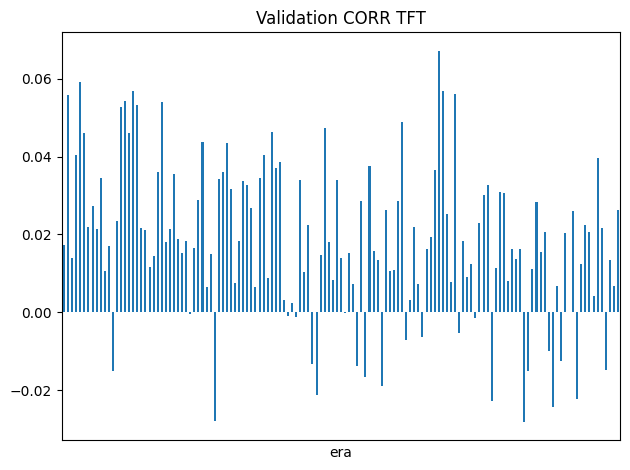

<Figure size 800x400 with 0 Axes>

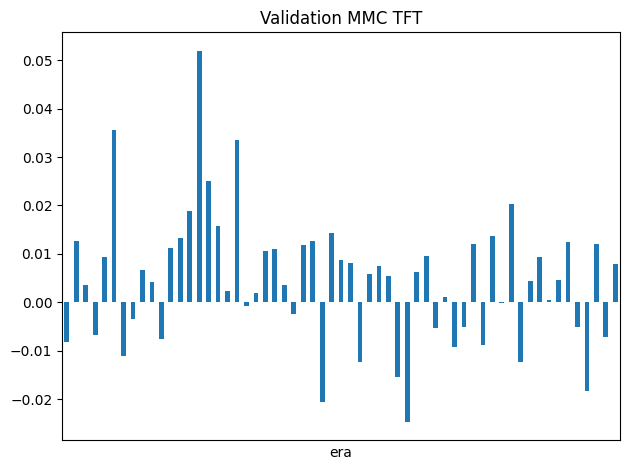

<Figure size 800x400 with 0 Axes>

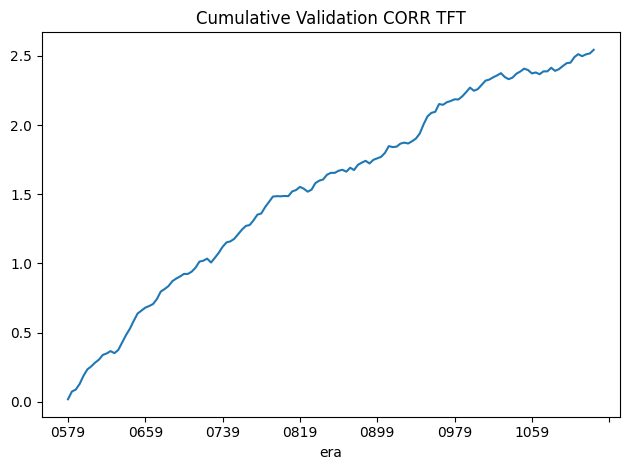

<Figure size 800x400 with 0 Axes>

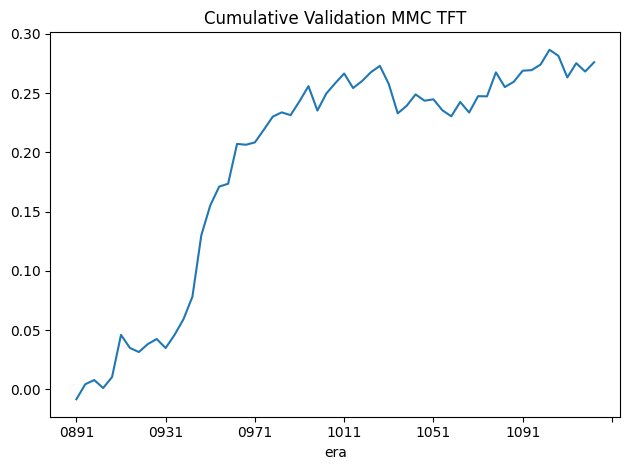

Mean Corr Numerai: prediction    0.018571
dtype: float64


C:\Users\Paco\AppData\Local\Temp\ipykernel_16540\1825904479.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  {'Modelo' : nombre_modelo , 'Parámetros' : parametros,'MAE': mae, 'MSE':mse, "Numerai Coor":mean_corr_numerai[0], 'MMC':mean_mmc_numerai[0]}


ValueError: If using all scalar values, you must pass an index

In [30]:
import metric_visualization as metric


df_pred= pd.DataFrame()
df_estadisticas =pd.DataFrame()

output_folder = "resultados_modelos/TFT"
nombre_modelo = "TFT"
os.makedirs(output_folder, exist_ok=True)

df_pred = pd.DataFrame()
df_estadisticas = pd.DataFrame()


df_pred, df_estadisticas = extract_metrics(validation,df_pred,  nombre_modelo, output_folder, None, df_estadisticas)


df_pred.to_parquet(f"{output_folder}/predicciones_{nombre_modelo}.parquet")
df_eras = metric.calculo_eras(validation, df_pred, output_folder, nombre_modelo)
df_eras.to_parquet(f"{output_folder}/correlaciones_eras_{nombre_modelo}.parquet")
df_estadisticas.to_excel(f"{output_folder}/Estadisticas_{nombre_modelo}.xlsx")

In [32]:
df =pd.DataFrame()
df["TFT"] = validation["prediction"]


In [33]:
df.to_parquet("resultados_modelos/TFT/prediccions_TFT.parquet")

In [16]:
y_test = validation["target"]
y_pred = preds_valid

validation["prediction"] = preds_valid

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)



print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

NameError: name 'mean_absolute_error' is not defined

In [17]:
preds_valid

array([[0.5085628 ],
       [0.4851906 ],
       [0.5242903 ],
       ...,
       [0.51687366],
       [0.54476947],
       [0.51282567]], dtype=float32)

In [18]:
validation

,era,target,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_adam_incantational_winemaker,feature_additive_untrustworthy_hierologist,...,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yauld_antediluvial_subprefecture,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,feature_zygodactyl_exponible_lathi,era_int,prediction
id,,,,,,,,,,,,,,,,,,,,,
n002a15bc5575bbb,0579,0.25,3,2,4,2,0,2,0,2,...,3,1,0,3,2,2,0,2,579,0.508563
n00309caaa0f955e,0579,0.50,4,2,0,2,1,2,0,1,...,0,3,1,2,0,2,0,0,579,0.485191
n00576b397182463,0579,0.50,0,1,2,3,0,3,0,2,...,1,1,4,2,2,4,1,4,579,0.524290
n00633405d59c6a1,0579,1.00,4,4,3,2,1,3,4,3,...,2,3,4,2,4,4,2,1,579,0.538148
n008c2eefc8911c7,0579,0.50,2,3,2,1,2,2,0,4,...,1,0,2,2,2,0,3,0,579,0.504640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffa94527bf7c49e,1119,0.50,2,3,3,1,3,1,1,1,...,1,1,3,1,0,2,4,4,1119,0.489410
nffaa698cb14f904,1119,0.75,2,4,0,2,2,3,1,0,...,0,2,4,1,0,3,4,0,1119,0.465980
nffbb9d43a110b56,1119,0.50,0,4,4,3,4,3,2,4,...,4,0,0,4,3,4,0,2,1119,0.516874
